In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/Users/juliankimura/Desktop/deepomics')
import deepomics.neuralnetwork as nn
from deepomics import learn, utils
from models import vae_model

import theano
import theano.tensor as T
from lasagne import layers

np.random.seed(247)   # for reproducibility

In [12]:
def load_dataset(data_path):
    import gzip
    def load_mnist_images(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 28*28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images(os.path.join(data_path,'train-images-idx3-ubyte.gz'))
    y_train = load_mnist_labels(os.path.join(data_path,'train-labels-idx1-ubyte.gz'))
    X_test = load_mnist_images(os.path.join(data_path,'t10k-images-idx3-ubyte.gz'))
    y_test = load_mnist_labels(os.path.join(data_path,'t10k-labels-idx1-ubyte.gz'))

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test


data_path = '/Users/juliankimura/Desktop/data/MNIST'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(data_path)


In [13]:
X_train.shape

(50000, 784)

In [14]:
shape = (None, X_train.shape[1])
network, placeholders, optimization = vae_model.model(shape)

In [16]:
# build neural network class
nnmodel = nn.NeuralNet(network, placeholders)
nnmodel.inspect_layers()

# set output file paths
output_name = 'MNIST_vae'
results_path = utils.make_directory(data_path, 'Results')
results_path = utils.make_directory(results_path, output_name)
file_path = os.path.join(results_path, output_name)
nntrainer = nn.NeuralTrainer(nnmodel, optimization, save='best', file_path=file_path)

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: 
shape:(None, 784)
layer2: 
shape:(None, 200)
parameters: W
layer3: 
shape:(None, 200)
parameters: beta, gamma, mean, inv_std
layer4: 
shape:(None, 200)
layer5: 
shape:(None, 200)
layer6: 
shape:(None, 100)
parameters: W
layer7: 
shape:(None, 100)
parameters: beta, gamma, mean, inv_std
layer8: 
shape:(None, 100)
layer9: 
shape:(None, 100)
layer10: 
shape:(None, 4)
parameters: W, b
layer11: 
shape:(None, 4)
parameters: W, b
layer12: 
shape:(None, 4)
layer13: 
shape:(None, 4)
layer14: 
shape:(None, 100)
parameters: W
layer15: 
shape:(None, 100)
parameters: b
layer16: 
shape:(None, 100)
layer17: 
shape:(None, 200)
parameters: W
layer18: 
shape:(None, 200)
parameters: b
layer19: 
shape:(None, 200)
layer20: 
shape:(None, 784)
parameters: W
layer21: 
shape:(None, 784)
parameters: b
layer22: 
shape:(None, 784)
-

In [18]:
# train model
learn.train_minibatch(nntrainer, data={'train': X_train, 'valid': X_val}, 
                              batch_size=100, num_epochs=500, patience=10, verbose=1)

Epoch 1 out of 500 


TypeError: Too many parameter passed to theano function

In [48]:
z_var = T.vector()
generated_x = layers.get_output(net['decode_mu'], {net['encode_mu']:z_var}, deterministic=True)
gen_fn = theano.function([z_var], generated_x)

num_grid = 20
pos = np.linspace(-2, 2, num_grid)
samples = []
for i in range(num_grid):
    for j in range(num_grid):
        z = np.asarray([pos[i], pos[j]], dtype=theano.config.floatX)
        samples.append(gen_fn(z))
samples = np.array(samples)        
                
plt.imsave(os.path.join(results_path,'MNIST_manifold.png'),
           (samples.reshape(num_grid, num_grid, 28, 20).transpose(0, 2, 1, 3)
            .reshape(num_grid*28, num_grid*20)), cmap='gray')

Starting training...
Epoch 1 of 10 took 32.593s
  training loss:		[ 0.96025641  0.99959936]
Epoch 2 of 10 took 32.969s
  training loss:		[ 0.94058494  0.99953926]
Epoch 3 of 10 took 32.854s
  training loss:		[ 0.95222356  0.99897837]
Epoch 4 of 10 took 32.921s
  training loss:		[ 0.96442308  0.99919872]
Epoch 5 of 10 took 33.268s
  training loss:		[ 0.95250401  0.99789663]
Epoch 6 of 10 took 32.721s
  training loss:		[ 0.93984375  0.99829728]
Epoch 7 of 10 took 32.951s
  training loss:		[ 0.0072516  0.9974359]
Epoch 8 of 10 took 32.625s
  training loss:		[ 0.62822516  0.97516026]
Epoch 9 of 10 took 32.624s
  training loss:		[ 0.9219351   0.98052885]
Epoch 10 of 10 took 32.601s
  training loss:		[ 0.92059295  0.99665465]


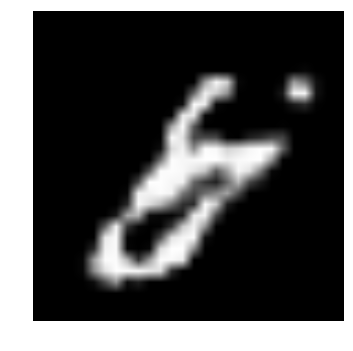

In [49]:
fig = plt.figure()
plt.imshow((samples.reshape(num_grid, num_grid, 28, 20)
                   .transpose(0, 2, 1, 3)
                   .reshape(num_grid*28, num_grid*20)), cmap='gray')
plt.axis('off')
fig.set_size_inches(20,20)

In [71]:
num_steps = 10
samples = X_train[:num_steps*num_steps]
plt.imsave(os.path.join(results_path,'MNIST_raw.png'), 
           (samples.reshape(num_steps, num_steps, 28, 20).transpose(0, 2, 1, 3)
            .reshape(num_steps*28, num_steps*20)), cmap='gray')